# Experimental with Leiden clustering and Wilcoxon for marker genes.

In [1]:
#def run_scanpy(clustering,resolution,path,cluster_names,ranking_genes_method)

In [2]:
!date
#Load libraries
import os,sys
import scanpy as sc
from scipy import sparse, io
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import numpy as np
import bioservices

vendredi 4 octobre 2019, 09:41:42 (UTC+0200)


In [3]:
#install pip install bioservices
#!{sys.executable} -m pip install bioservices
#!{sys.executable} -m pip install rpy2
#!{sys.executable} -m pip install mygene
#!{sys.executable} -m pip install goatools
#For leiden neighbouring "which is supposed to be upgraded and better performing clusters"
#Install leidenalg
#!{sys.executable} -m pip install leidenalg


### Create adata

In [4]:
#Select the path to the genecounts 
path2data="/mnt/haus/marius/SingleCell10xKallistoJupyter/busOutputs/experimental/genecount/"

In [5]:
#Get the genes instead of ensembl gene ids...
genes=pd.read_csv(path2data + "genes.genes.txt",header = None,names=["geneID"])
var_names=pd.DataFrame([ names for names in genes["geneID"]],columns=["geneID"])
print(var_names.shape)
var_names.head()
#Map the ensembl id to the gene names.
genes_and_transcript_ensembl_R=pd.DataFrame(pd.read_csv("/mnt/haus/marius/SingleCell10xKallistoJupyter/transcripts2genes.txt",sep="\t",header=None,names=["transcript","geneID","symbol"]))
genes_and_transcript_ensembl_R.set_index("geneID")
genes_and_transcript_ensembl_R.sort_index(inplace=True)
genes_and_transcript_ensembl_R.drop_duplicates(subset="geneID",inplace=True)
df1=pd.merge(var_names,genes_and_transcript_ensembl_R,left_on="geneID",right_on="geneID",how="left")#,right_on="geneID", and only the data from var_names and any of the right matching in the left
df1['symbol'] = df1['symbol'].str.upper() 
print(df1.shape)
df1.head()


(30628, 1)
(30628, 3)


,geneID,transcript,symbol
0,ENSDARG00000063344,ENSDART00000131829,FAM162A
1,ENSDARG00000097685,ENSDART00000156963,SI:CH211-235I11.3
2,ENSDARG00000036008,ENSDART00000137179,CALY
3,ENSDARG00000069301,ENSDART00000100744,TMEM177
4,ENSDARG00000104901,ENSDART00000167980,OSTC


In [6]:
print(df1[df1["geneID"]=="ENSDARG00000031420"])
print(df1[df1["geneID"]=="ENSDARG00000007990"])
print("ENSDARG00000007990" in var_names)
"ENSDARG00000031420" in var_names

                  geneID          transcript symbol
7299  ENSDARG00000031420  ENSDART00000031499   WT1A
                   geneID          transcript symbol
18603  ENSDARG00000007990  ENSDART00000146543   WT1B
False


False

In [7]:
#save it to read later.
df1.to_csv(r'/mnt/haus/marius/SingleCell10xKallistoJupyter/busOutputs/df1_genes_from_genes_counts_experimental.txt',index=False,header=False)


In [8]:
ab = pd.read_csv("/mnt/haus/marius/SingleCell10xKallistoJupyter/busOutputs/df1_genes_from_genes_counts_experimental.txt",header = None)[2]
nw_dt=[]
for i in ab:
    j = str(i).replace(' ','')
    nw_dt.append(j)

### Load the genes matrix

In [9]:
#Load the genes matrix, and use the observations → barcodes
#Load the genes names as variables from the matrix
adata = sc.read_mtx(path2data + "genes.mtx")
adata.obs.index = pd.read_csv(path2data + "genes.barcodes.txt",header = None)[0].values
#Use the converted table and the gene names.
#adata.var.index = pd.read_csv(path2data + "genes.genes.txt",header = None)[0].values
adata.var.index = nw_dt

### Preprocessing
#### Show those genes that yield the highest fraction of counts in each single cells, across all cells.



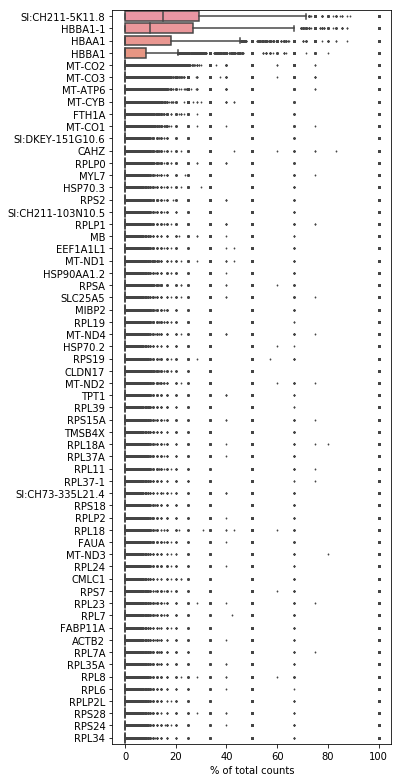

In [10]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'
sc.pl.highest_expr_genes(adata, n_top=60)

In [11]:
#Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

##### Let us assemple some information about mitochondrial genes, which are important for quality control.
High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [12]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

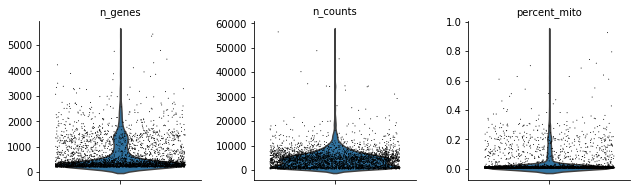

In [13]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

#### Remove cells that have too many mitochondrial genes expressed or too many total counts.



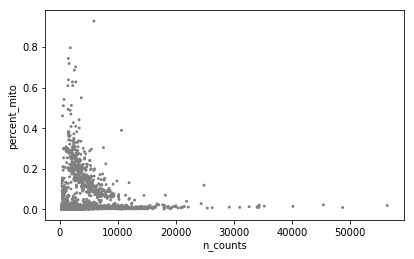

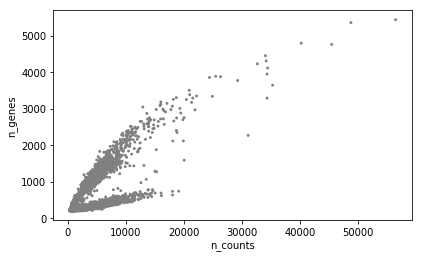

In [14]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [15]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

#### Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.



In [16]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Trying to set attribute `.obs` of view, making a copy.


#### Logarithmize the data.


In [17]:
sc.pp.log1p(adata)


Set the .raw attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object. While many people consider the normalized data matrix as the “relevant data” for visualization and differential testing, some would prefer to store the unnormalized data.

In [18]:
adata.raw = adata


#### Identify highly-variable genes.


In [19]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


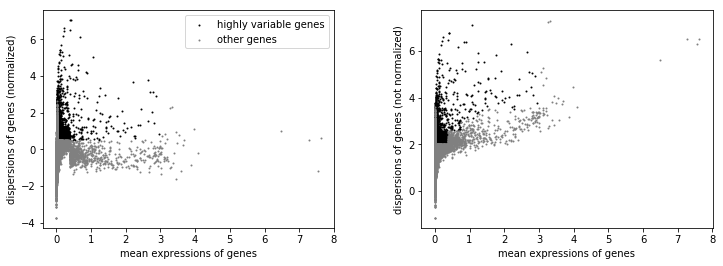

In [20]:
sc.pl.highly_variable_genes(adata)


#### Actually do the filtering.



In [21]:
adata = adata[:, adata.var['highly_variable']]

# Numero de celulas viables: mirar obs

In [22]:
adata

View of AnnData object with n_obs × n_vars = 2927 × 4211 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

#### Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [23]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])


#### Scale each gene to unit variance. Clip values exceeding standard deviation 10.



In [24]:
sc.pp.scale(adata, max_value=10)


#### Principal component analysis  

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [25]:
sc.tl.pca(adata, svd_solver='arpack') #SVD solver to use:``'arpack'``for the ARPACK wrapper in SciPy (:func:`~scipy.sparse.linalg.svds`)


Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). In our experience, often, a rough estimate of the number of PCs does fine.

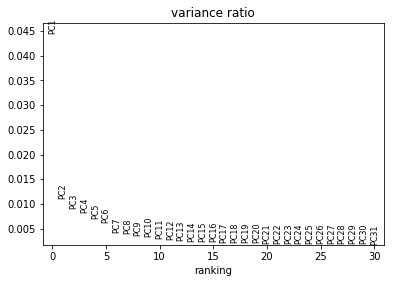

In [26]:
sc.pl.pca_variance_ratio(adata)#, log=True)

### Neighbours

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. __For the sake of reproducing Seurat’s results, let’s take the following values.__

In [27]:
sc.pp.neighbors(adata)#, n_neighbors=10, n_pcs=40)


#### Embedding the neighborhood graph

We advertise embedding the graph in 2 dimensions using UMAP (McInnes et al., 2018), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

`tl.paga(adata)`  
`pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph`  
`tl.umap(adata, init_pos='paga')`  

In [28]:
sc.tl.umap(adata)


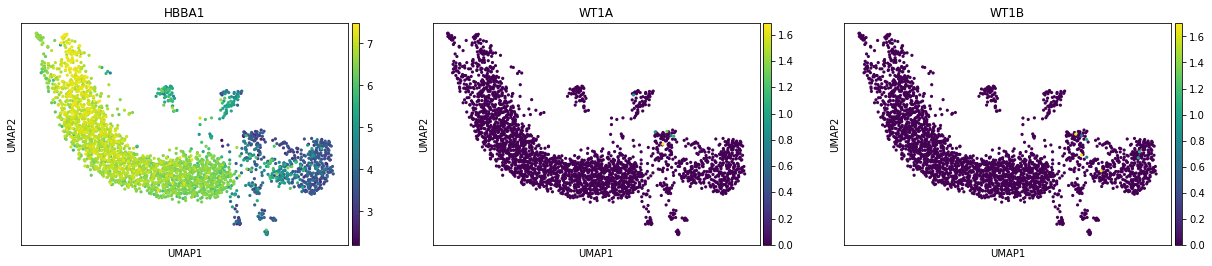

In [29]:
sc.pl.umap(adata, color=['HBBA1', 'WT1A', 'WT1B'])


As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw.

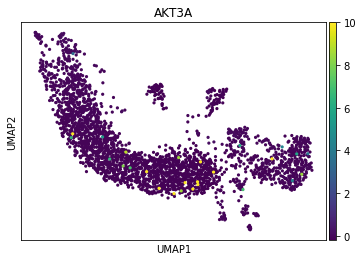

In [30]:
#plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw
#Need to change the data as in the SCALED and CORRECTED gene expression they do not appear. 
sc.pl.umap(adata,color = ["AKT3A"],use_raw=False)


In [31]:
#Get the clusters based on the neighborhood graph of cells... which we already computed with neighborhoods


#sc.tl.louvain(adata,resolution=1)


# Use leiden

In [32]:
sc.tl.leiden(adata,resolution=1)

In [33]:
#Plot the cells, and the cluster
#sc.pl.umap(adata, color=['louvain', 'HBBA1',"WT1A","WT1B"])#'LEO1'

#sc.pl.umap(adata, color=['louvain', 'WT1A', 'HBBA1'])


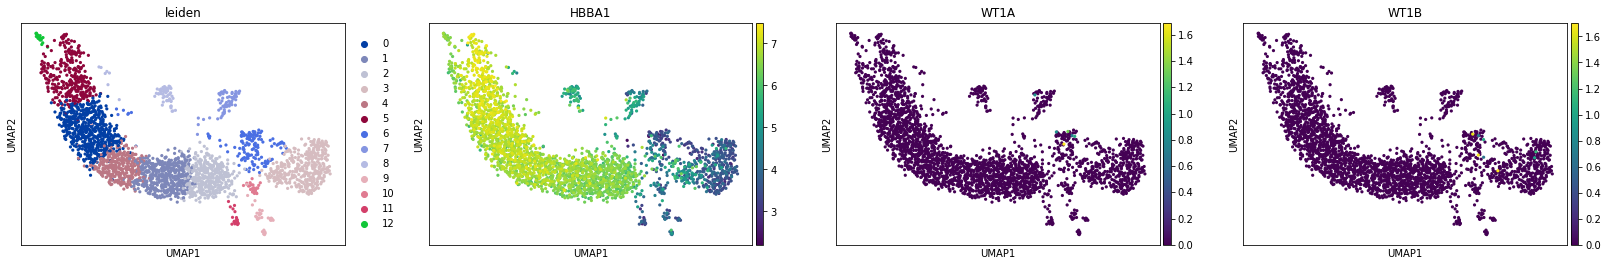

In [34]:
#Plot the cells, and the cluster
sc.pl.umap(adata, color=['leiden', 'HBBA1',"WT1A","WT1B"])#'LEO1'

#sc.pl.umap(adata, color=['louvain', 'WT1A', 'HBBA1'])


# Finding marker genes

* Ranking for the highly differential genes in each cluster.
* The simplest and fastest method to do so is the t-test

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the **t-test**.


The result of a **Wilcoxon rank-sum (Mann-Whitney-U) test is very similar**. We recommend using the latter in publications, see e.g., Sonison & Robinson (2018). 

`sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')`  
`sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)`


Can also be tested with logistic regression:  

For instance, this has been suggested by Natranos et al. (2018). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. Clark et al. (2014) has more details.

`sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')`  
`sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)`


In [35]:
# Can also be done with a more powerful test in Wilcoxon rank sum Mann whitney U
#sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

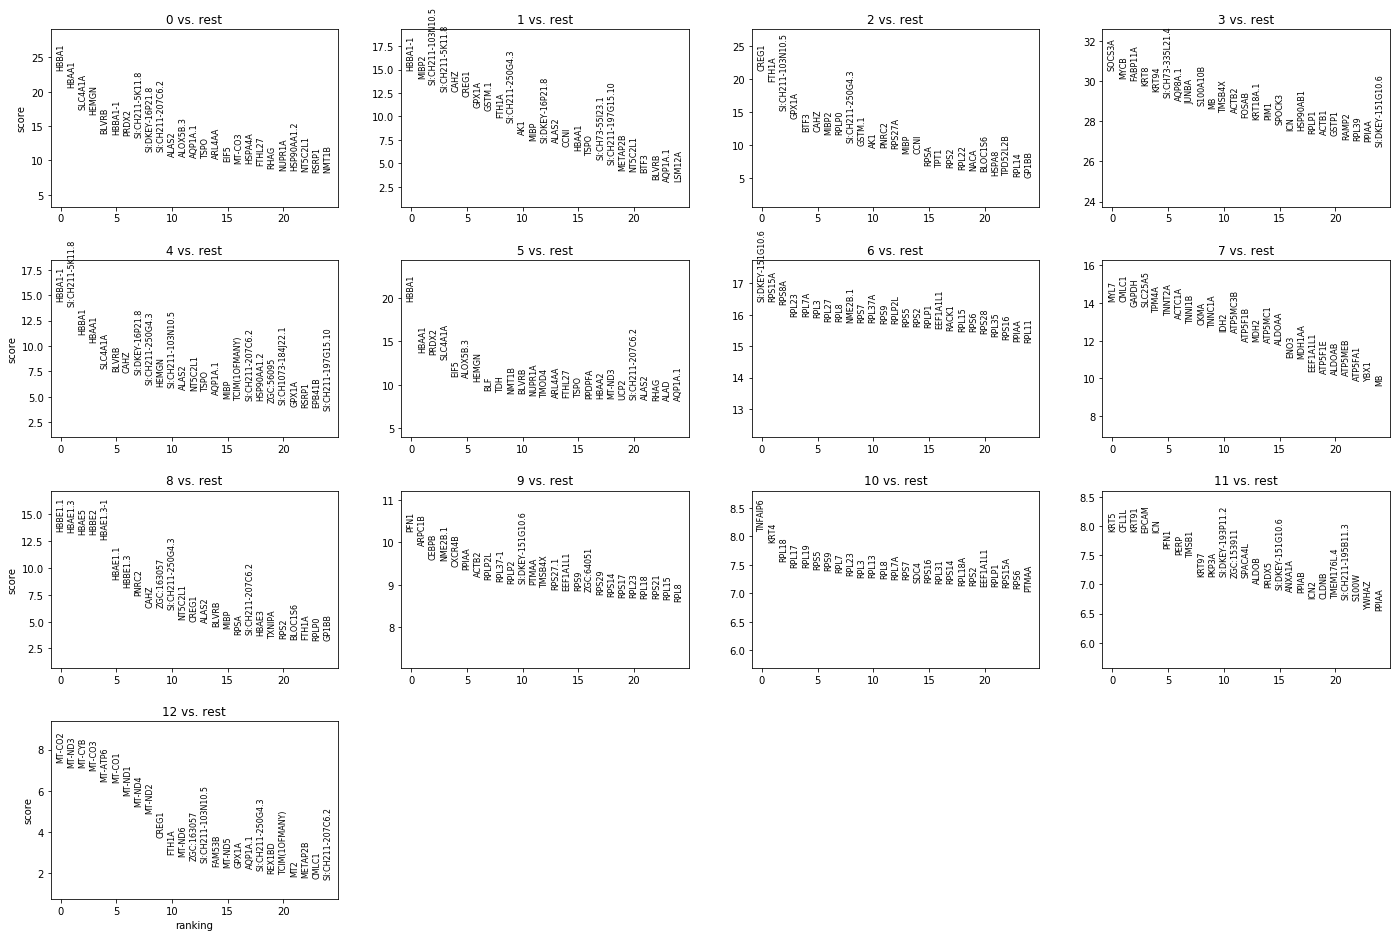

In [36]:
# Can also be done with a more powerful test in Wilcoxon rank sum Mann whitney U
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [37]:
os.getcwd()
os.chdir('/mnt/haus/marius/SingleCell10xKallistoJupyter/JupyterNotebooks')

In [38]:
results_file="/mnt/haus/marius/SingleCell10xKallistoJupyter/results_experimental_leiden.h5ad"
adata.write(results_file)


### Show the 10 top ranked genes per cluster in a dataframe.


In [39]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(11)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,HBBA1,HBBA1-1,CREG1,SOCS3A,HBBA1-1,HBBA1,SI:DKEY-151G10.6,MYL7,HBBE1.1,PFN1,TNFAIP6,KRT5,MT-CO2
1,HBAA1,MIBP2,FTH1A,MYCB,SI:CH211-5K11.8,HBAA1,RPS15A,CMLC1,HBAE1.3,ARPC1B,KRT4,CFL1L,MT-ND3
2,SLC4A1A,SI:CH211-103N10.5,SI:CH211-103N10.5,FABP11A,HBBA1,PRDX2,RPS8A,GAPDH,HBAE5,CEBPB,RPL18,KRT91,MT-CYB
3,HEMGN,SI:CH211-5K11.8,GPX1A,KRT8,HBAA1,SLC4A1A,RPL23,SLC25A5,HBBE2,NME2B.1,RPL17,EPCAM,MT-CO3
4,BLVRB,CAHZ,BTF3,KRT94,SLC4A1A,EIF5,RPL7A,TPM4A,HBAE1.3-1,CXCR4B,RPL19,ICN,MT-ATP6
5,HBBA1-1,CREG1,CAHZ,SI:CH73-335L21.4,BLVRB,ALOX5B.3,RPL3,TNNT2A,HBAE1.1,PPIAA,RPS5,PFN1,MT-CO1
6,PRDX2,GPX1A,MIBP2,AQP8A.1,CAHZ,HEMGN,RPL27,ACTC1A,HBBE1.3,ACTB2,RPS9,PERP,MT-ND1
7,SI:CH211-5K11.8,GSTM.1,RPLP0,JUNBA,SI:DKEY-16P21.8,BLF,RPL8,TNNI1B,PNRC2,RPLP2L,RPL7,TMSB1,MT-ND4
8,SI:DKEY-16P21.8,FTH1A,SI:CH211-250G4.3,S100A10B,SI:CH211-250G4.3,TDH,NME2B.1,CKMA,CAHZ,RPL37-1,RPL23,KRT97,MT-ND2
9,SI:CH211-207C6.2,SI:CH211-250G4.3,GSTM.1,MB,HEMGN,NMT1B,RPS7,TNNC1A,ZGC:163057,RPLP2,RPL3,PKP3A,CREG1


In [40]:
df_experimental_leiden=pd.DataFrame(adata.uns['rank_genes_groups']['names'])
df_experimental_leiden.to_csv(os.path.join(os.getcwd()+"/df_experimental_leiden.txt"),sep="\t",header=True)
df_experimental_leiden

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,HBBA1,HBBA1-1,CREG1,SOCS3A,HBBA1-1,HBBA1,SI:DKEY-151G10.6,MYL7,HBBE1.1,PFN1,TNFAIP6,KRT5,MT-CO2
1,HBAA1,MIBP2,FTH1A,MYCB,SI:CH211-5K11.8,HBAA1,RPS15A,CMLC1,HBAE1.3,ARPC1B,KRT4,CFL1L,MT-ND3
2,SLC4A1A,SI:CH211-103N10.5,SI:CH211-103N10.5,FABP11A,HBBA1,PRDX2,RPS8A,GAPDH,HBAE5,CEBPB,RPL18,KRT91,MT-CYB
3,HEMGN,SI:CH211-5K11.8,GPX1A,KRT8,HBAA1,SLC4A1A,RPL23,SLC25A5,HBBE2,NME2B.1,RPL17,EPCAM,MT-CO3
4,BLVRB,CAHZ,BTF3,KRT94,SLC4A1A,EIF5,RPL7A,TPM4A,HBAE1.3-1,CXCR4B,RPL19,ICN,MT-ATP6
5,HBBA1-1,CREG1,CAHZ,SI:CH73-335L21.4,BLVRB,ALOX5B.3,RPL3,TNNT2A,HBAE1.1,PPIAA,RPS5,PFN1,MT-CO1
6,PRDX2,GPX1A,MIBP2,AQP8A.1,CAHZ,HEMGN,RPL27,ACTC1A,HBBE1.3,ACTB2,RPS9,PERP,MT-ND1
7,SI:CH211-5K11.8,GSTM.1,RPLP0,JUNBA,SI:DKEY-16P21.8,BLF,RPL8,TNNI1B,PNRC2,RPLP2L,RPL7,TMSB1,MT-ND4
8,SI:DKEY-16P21.8,FTH1A,SI:CH211-250G4.3,S100A10B,SI:CH211-250G4.3,TDH,NME2B.1,CKMA,CAHZ,RPL37-1,RPL23,KRT97,MT-ND2
9,SI:CH211-207C6.2,SI:CH211-250G4.3,GSTM.1,MB,HEMGN,NMT1B,RPS7,TNNC1A,ZGC:163057,RPLP2,RPL3,PKP3A,CREG1


#### Get a table with the scores and groups.

In [41]:
os.getcwd()

'/mnt/haus/marius/SingleCell10xKallistoJupyter/JupyterNotebooks'

In [42]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

df_with_p_values_experimental_leiden=pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']})
df_with_p_values_experimental_leiden.to_csv(os.path.join(os.getcwd()+"/df_with_p_values_experimental_leiden.txt"),sep="\t",header=True)
df_with_p_values_experimental_leiden.head()

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p
0,HBBA1,1.531656e-118,HBBA1-1,1.571714e-50,CREG1,1.510585e-101,SOCS3A,4.484501e-205,HBBA1-1,2.639187e-47,...,HBBE1.1,8.204386e-41,PFN1,1.078569e-24,TNFAIP6,6.459466e-16,KRT5,2.628649e-15,MT-CO2,1.590209e-13
1,HBAA1,4.595484e-95,MIBP2,7.885619e-45,FTH1A,1.923693e-86,MYCB,9.598310e-200,SI:CH211-5K11.8,3.513335e-44,...,HBAE1.3,9.056646e-41,ARPC1B,2.728600e-23,KRT4,2.871641e-15,CFL1L,2.628649e-15,MT-ND3,8.935589e-13
2,SLC4A1A,5.414123e-68,SI:CH211-103N10.5,4.196616e-41,SI:CH211-103N10.5,3.195379e-53,FABP11A,1.908073e-198,HBBA1,9.563212e-29,...,HBAE5,2.983764e-39,CEBPB,7.320521e-22,RPL18,3.848115e-14,KRT91,2.645110e-15,MT-CYB,1.020357e-12
3,HEMGN,7.981892e-63,SI:CH211-5K11.8,3.480687e-37,GPX1A,1.877202e-45,KRT8,3.055994e-195,HBAA1,1.984166e-25,...,HBBE2,3.097274e-39,NME2B.1,8.605629e-22,RPL17,8.421818e-14,EPCAM,2.656140e-15,MT-CO3,2.288665e-12
4,BLVRB,1.693774e-44,CAHZ,4.789921e-37,BTF3,1.359445e-33,KRT94,1.270710e-191,SLC4A1A,5.155173e-15,...,HBAE1.3-1,6.762997e-37,CXCR4B,3.261500e-21,RPL19,8.554669e-14,ICN,2.904556e-15,MT-ATP6,9.642453e-11


### For a more detailed wiew of a group, change from 0 to 11...

and see the differences and n_genes up to user.

/home/marius/anaconda3/envs/py36/lib/python3.6/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


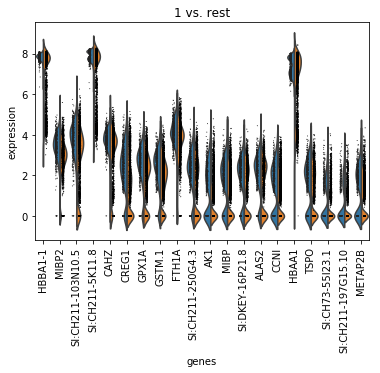

In [43]:
sc.pl.rank_genes_groups_violin(adata, groups="1", n_genes=20)


### Compare to a single cluster.

Compare group 9 vs reference up to user both.. using wilcoxon modelling.



In [44]:
#sc.tl.rank_genes_groups(adata, 'louvain', groups=['9'], reference='7', method='wilcoxon')
#sc.pl.rank_genes_groups(adata, groups=["9"], n_genes=20)

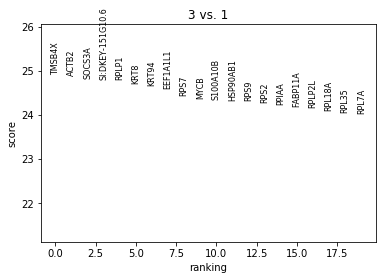

In [45]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['3'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=["3"], n_genes=20)

### If you want to compare a certain gene across groups (louvain clusters), use the following.


In [46]:
#sc.pl.violin(adata, ['WT1A', 'WT1B', 'HBBA1',"MYL7"], groupby='louvain')


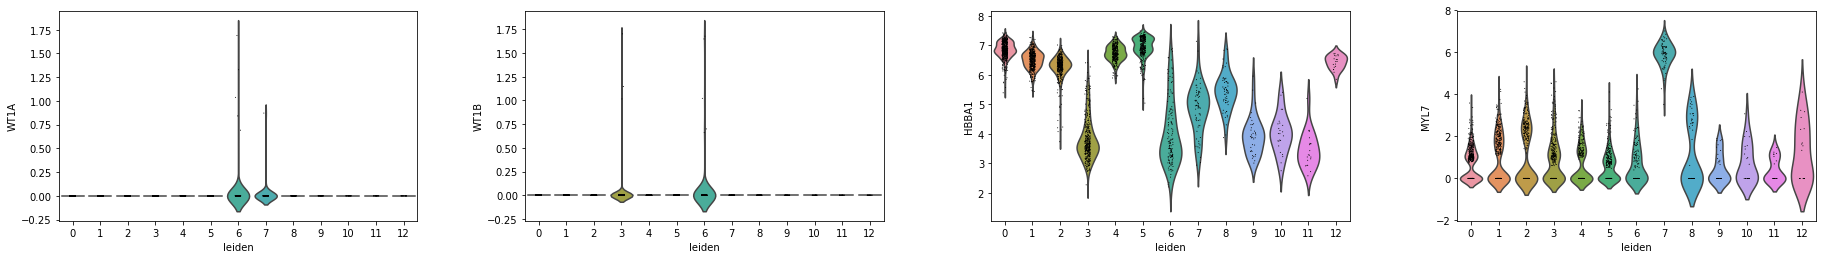

In [47]:
sc.pl.violin(adata, ['WT1A', 'WT1B', 'HBBA1',"MYL7"], groupby='leiden')


In [48]:
#adata = sc.read(results_file)


# Get the names of the clusters bassed on the annotations previously generated

# Using R with the data frame generated with the clusters genes names, transform them and perform an enrichment for determining the cluster type and perform the last step o naming and tsne.

In [49]:
#new_cluster_names = [
#    'CD4 T', 'CD14+ Monocytes',
#    'B', 'CD8 T',
#    'NK', 'FCGR3A+ Monocytes',
#    'Dendritic', 'Megakaryocytes']
#adata.rename_categories('leiden', new_cluster_names)

In [50]:
#sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False, save='_experimental.pdf')

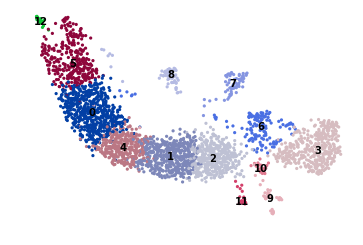

In [51]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='_experimental_leiden.pdf')

In [52]:
#sc.pl.heatmap(adata,adata.var_names,groupby="louvain")#,show_gene_labels=True)

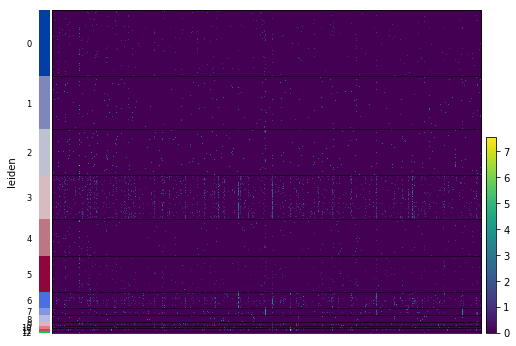

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 8, 0, 0.2])

In [53]:
sc.pl.heatmap(adata,adata.var_names,groupby="leiden",save='_experimental_leiden.pdf')#,show_gene_labels=True)

In [54]:
#sc.pl.rank_genes_groups_heatmap(adata, n_genes=10, groupby="louvain",show_gene_labels=True)

categories: 0, 1, 2, etc.
var_group_labels: 3


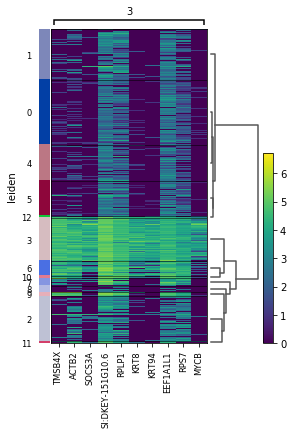

In [55]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=10, groupby="leiden",show_gene_labels=True,save='_2_experimental_leiden.pdf')

# PCA

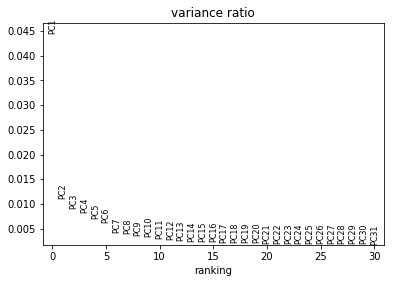

In [56]:
sc.pl.pca_variance_ratio(adata)#, log=True)


#### The distribution of the PCAS using louvain clustering.

In [57]:
#sc.pl.pca(adata, color="louvain")#, ax=ax)


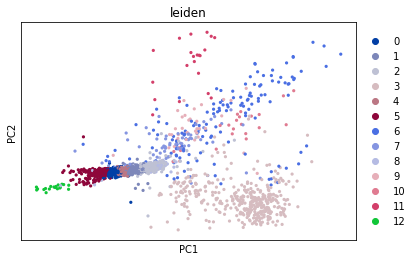

In [58]:
sc.pl.pca(adata, color="leiden",save='_experimental_leiden.pdf')#, ax=ax)


# tSNE

In [59]:
sc.tl.tsne(adata)#, n_pcs=10)


In [60]:
#sc.pl.tsne(adata, color="louvain")#, ax=ax, save="getting_started_tsne.png")

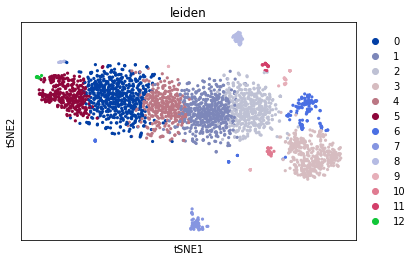

In [61]:
sc.pl.tsne(adata, color="leiden",save="_experimental_leiden.pdf")#, ax=ax, save="getting_started_tsne.png")

# diffMap

In [62]:
sc.tl.diffmap(adata)

In [63]:
#sc.pl.diffmap(adata, color='louvain')


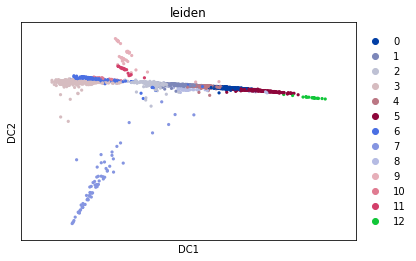

In [64]:
sc.pl.diffmap(adata, color='leiden',save="_experimental_leiden.pdf")


# Leiden instead of louvain and changing resolution factor.

In [65]:
sc.tl.leiden(adata, resolution=2)

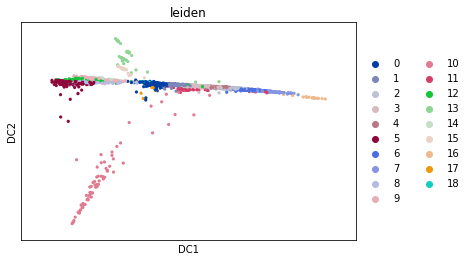

In [66]:
sc.pl.diffmap(adata, color='leiden',save="_experimental_leiden_2_resolution.pdf")


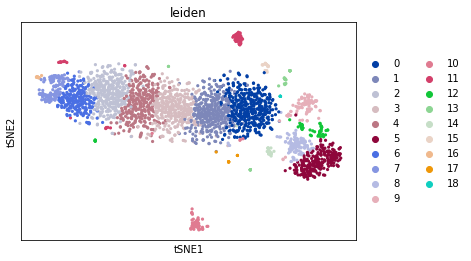

In [67]:
sc.pl.tsne(adata, color="leiden",save="_experimental_leiden_2_resolution.pdf")#, ax=ax, save="getting_started_tsne.png")

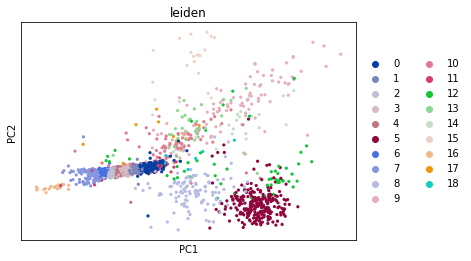

In [68]:
sc.pl.pca(adata, color="leiden",save="_experimental_leiden_2_resolution.pdf")#, ax=ax)


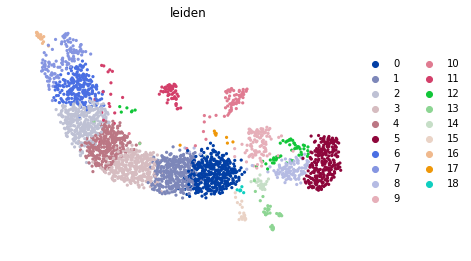

In [69]:
sc.pl.umap(adata, color='leiden',frameon=False, save="_experimental_leiden_2_resolution.pdf")

In [70]:
os.mkdir("/mnt/haus/marius/SingleCell10xKallistoJupyter/R")


FileExistsError: [Errno 17] File exists: '/mnt/haus/marius/SingleCell10xKallistoJupyter/R'

In [71]:
os.system("cp /mnt/haus/marius/old_SingleCell10xKallistoJupyter/R/*.R /mnt/haus/marius/SingleCell10xKallistoJupyter/R/")

0

In [ ]:
#Run R script for Experimental path.